In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
sns.set()

list_of_columns = [
 'home',
 'away',
 'date',
 'venue',
 'league',
 'part_of_competition',
 'home_score',
 'away_score',
 'home_possessionPct',
 'away_possessionPct',
 'home_shotsSummary',
 'away_shotsSummary',
 'home_foulsCommitted',
 'away_foulsCommitted',
 'home_yellowCards',
 'away_yellowCards',
 'home_redCards',
 'away_redCards',
 'home_offsides',
 'away_offsides',
 'home_wonCorners',
 'away_wonCorners',
 'home_saves',
 'away_saves'
]

def strip_perc_symbol(perc):
    return float(perc.strip('%'))

def shots(shot_summary):
    interm_string = shot_summary.strip(')')
    entries = interm_string.split('(')
    return int(entries[0])

def shots_on_goal(shot_summary):
    interm_string = shot_summary.strip(')')
    entries = interm_string.split('(')
    return int(entries[1])


from sklearn.base import BaseEstimator, TransformerMixin
class FeaturesSubsetter(BaseEstimator, TransformerMixin):
    def __init__(self, subset=True):
        self.subset=subset
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        if self.subset:
            return X.loc[:, list_of_columns]
        else:
            return X 

class NaDropper(BaseEstimator, TransformerMixin):
    def __init__(self, format=True):
        self.format=format
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        return X.dropna() 


class PctFormatter(BaseEstimator, TransformerMixin):
    def __init__(self, format=True):
        self.format=format
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.format:
            X['home_possessionPct'] = X['home_possessionPct'].apply(strip_perc_symbol)
            X['away_possessionPct'] = X['away_possessionPct'].apply(strip_perc_symbol)

        return X

class SummaryFormatter(BaseEstimator, TransformerMixin):
    def __init__(self, format=True):
        self.format=format
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        if self.format:
            X['home_shots'] = X['home_shotsSummary'].apply(shots)
            X['home_shots_on_goal'] = X['home_shotsSummary'].apply(shots_on_goal)
            X = X.drop('home_shotsSummary', axis=1)

            X['away_shots'] = X['away_shotsSummary'].apply(shots)
            X['away_shots_on_goal'] = X['away_shotsSummary'].apply(shots_on_goal)
            X = X.drop('away_shotsSummary', axis=1)

        return X


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
    ('subsetter', FeaturesSubsetter()), 
    ('na_dropper', NaDropper()),
    ('pct_formatter', PctFormatter()), 
    ('summary_formatter', SummaryFormatter())
])
      

num_attribs = [
 'home_possessionPct',
 'away_possessionPct',
 'home_foulsCommitted',
 'away_foulsCommitted',
 'home_yellowCards',
 'away_yellowCards',
 'home_redCards',
 'away_redCards',
 'home_offsides',
 'away_offsides',
 'home_wonCorners',
 'away_wonCorners',
 'home_saves',
 'away_saves', 
 'home_shots',
 'home_shots_on_goal',
 'away_shots',
 'away_shots_on_goal'
]

cat_attribs = [
 'home',
 'away',
 'league'
]



from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

column_transf = ColumnTransformer([
 ("cat", OneHotEncoder(), cat_attribs),
 ("num", StandardScaler(), num_attribs)
 ])



In [2]:
# full_pipeline = Pipeline([
#     ('pipe', pipeline) ,
#     ('col_tr', column_transf)         
# ])
df = pd.read_csv('matches.csv')
df = pipeline.fit_transform(df)
y_1 = df['home_score']
y_2 = df['away_score']
df.drop(['home_score', 'away_score'], axis=1, inplace=True)
matrix = column_transf.fit_transform(df).toarray()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11,14,50,102,123,125,129,131,133,135,137,139,141,143,145,147,149,157,158,160,161,163,165,167,169,171,173,184,186,187,205,206) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(matrix, y_1, test_size=0.2)

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()
    plt.ylim(0,1)
    plt.show()

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict

def eval_reg(reg):
    y_train_pred = cross_val_predict(reg, X_train, y_train, cv=10)
    print("rmse: ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
    plot_learning_curves(reg, X_train, y_train)

In [27]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

param_grid = [{'alpha':[0.01, 0.1, 1, 10, 100]}]
ridge_reg = Ridge()

ridge_reg_grid = GridSearchCV(ridge_reg, param_grid, scoring='neg_mean_squared_error')
ridge_reg_grid.fit(X_train, y_train)

best_ridge = ridge_reg_grid.best_estimator_

ridge_reg_grid.best_params_

{'alpha': 1}

In [19]:
from sklearn.linear_model import Lasso

param_grid = [{'alpha':[0.0001, 0.001, 0.01, 0.1, 1]}]
lasso_reg = Lasso()

lasso_reg_grid = GridSearchCV(lasso_reg, param_grid, scoring='neg_mean_squared_error')
lasso_reg_grid.fit(X_train, y_train)

best_lasso = lasso_reg_grid.best_estimator_

lasso_reg_grid.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1179254529180298, tolerance: 0.4734525986842106
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.116978210864886, tolerance: 0.46796631578947384
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0939086680964465, tolerance: 0.46977881578947384
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergenc

{'alpha': 0.001}

In [20]:
from sklearn.svm import LinearSVR

param_grid = [{'epsilon':[0.01, 0.1, 1, 10, 100]}]
svr_reg = LinearSVR()

svr_reg_grid = GridSearchCV(svr_reg, param_grid, scoring='neg_mean_squared_error')
svr_reg_grid.fit(X_train, y_train)

best_svr = svr_reg_grid.best_estimator_

svr_reg_grid.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

{'epsilon': 0.1}

In [21]:
from sklearn.tree import DecisionTreeRegressor

param_grid = [{'max_depth':[1, 10, 100]}]
tree_reg = DecisionTreeRegressor()
tree_reg_grid = GridSearchCV(tree_reg, param_grid, scoring='neg_mean_squared_error')
tree_reg_grid.fit(X_train, y_train)

best_tree = tree_reg_grid.best_estimator_

tree_reg_grid.best_params_

{'max_depth': 10}

linear 

rmse:  1708219604.5314384


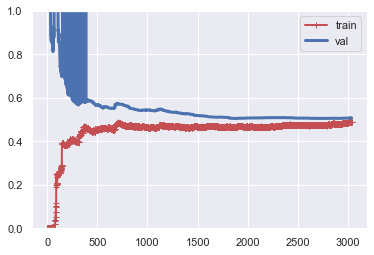

ridge 

rmse:  0.5037140531934992


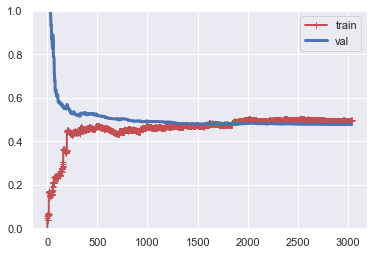

lasso 

rmse:  0.5020286446138373


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012591137148463025, tolerance: 0.00045000000000000004
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005289135553707861, tolerance: 0.0004666666666666667
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objectiv

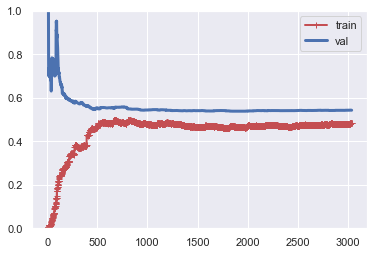

svr 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

rmse:  0.5430541312970649


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

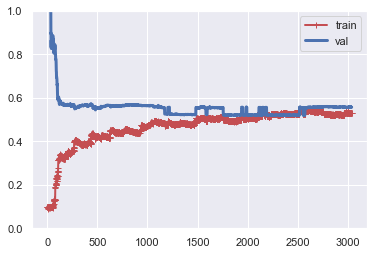

tree 

rmse:  0.5756673623187125


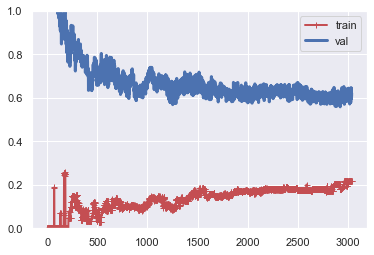

In [28]:
regressors = [('linear', lin_reg), ('ridge', best_ridge), ('lasso', best_lasso), ('svr', best_svr), ('tree', best_tree)]

for regr_name, regr in regressors:
    print(regr_name, "\n")
    eval_reg(regr)

## On the test set 

In [29]:
y_test_pred = best_lasso.predict(X_test)
print("rmse: ", np.sqrt(mean_squared_error(y_test, y_test_pred)))

rmse:  0.4990560320955848
